In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import numpy as np
from spreg import OLS
import statsmodels.api as sm

In [2]:
# Read in all the data

AQMS_df=pd.read_csv('data/AQMS_readings.csv')
Rd_gdf=gpd.read_file('data/london_Road.shp')
Gsp_gdf=gpd.read_file('data/LD_GreenSpace.shp')
loc_gdf=gpd.read_file('data/AQMS_loc.shp')
cond=pd.read_csv('data/cond.csv')

In [3]:
AQMS_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DateTime  8760 non-null   object 
 1   Value     7753 non-null   float64
 2   Site      8760 non-null   object 
dtypes: float64(1), object(2)
memory usage: 205.4+ KB


In [4]:
Rd_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 209201 entries, 0 to 209200
Data columns (total 20 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   fictitious  209201 non-null  object  
 1   identifier  209201 non-null  object  
 2   class       209201 non-null  object  
 3   roadNumber  32375 non-null   object  
 4   name1       172339 non-null  object  
 5   name1_lang  0 non-null       object  
 6   name2       0 non-null       object  
 7   name2_lang  0 non-null       object  
 8   formOfWay   209201 non-null  object  
 9   length      209201 non-null  int64   
 10  primary     209201 non-null  object  
 11  trunkRoad   209201 non-null  object  
 12  loop        209201 non-null  object  
 13  startNode   209201 non-null  object  
 14  endNode     209201 non-null  object  
 15  structure   93 non-null      object  
 16  nameTOID    172339 non-null  object  
 17  numberTOID  32375 non-null   object  
 18  function    2092

In [5]:
Gsp_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10021 entries, 0 to 10020
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   function   10021 non-null  object  
 1   distName1  2679 non-null   object  
 2   distName2  11 non-null     object  
 3   distName3  0 non-null      object  
 4   distName4  0 non-null      object  
 5   geometry   10021 non-null  geometry
dtypes: geometry(1), object(5)
memory usage: 469.9+ KB


In [6]:
loc_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   siteid    24 non-null     object  
 1   sitename  24 non-null     object  
 2   geometry  24 non-null     geometry
dtypes: geometry(1), object(2)
memory usage: 704.0+ bytes


In [7]:
cond.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DateTime  365 non-null    object 
 1   BP        364 non-null    float64
 2   Tmp       358 non-null    float64
 3   RH        364 non-null    float64
dtypes: float64(3), object(1)
memory usage: 11.5+ KB


In [14]:
site_name=AQMS_df['Site'].unique().tolist()

In [21]:
AQMS_df['code']=0

for i in range(len(site_name)):
    AQMS_df['code']=AQMS_df['code']+(i+1)*(AQMS_df['Site']==site_name[i])

In [28]:
AQMS_df.merge(cond,how='left',on='DateTime').corr()

,Value,code,BP,Tmp,RH
Value,1.000000,2.441632e-02,2.475024e-01,-1.503485e-01,-3.734312e-02
code,0.024416,1.000000e+00,-4.814873e-14,2.943959e-15,-9.310433e-15
BP,0.247502,-4.814873e-14,1.000000e+00,5.589302e-02,-3.787873e-01
Tmp,-0.150348,2.943959e-15,5.589302e-02,1.000000e+00,-4.517946e-01
RH,-0.037343,-9.310433e-15,-3.787873e-01,-4.517946e-01,1.000000e+00


In [29]:
# reindex loc_gdf and set buffer zones around each site (1km)

loc_gdf=loc_gdf.set_index('siteid')
loc_gdf['buffer_1km']=loc_gdf['geometry'].buffer(1000)
loc_gdf.head()

,sitename,geometry,buffer_1km
siteid,,,
BX9,Bexley - Slade Green FDMS,POINT (551862.205 176375.976),"POLYGON ((552862.205 176375.976, 552857.390 17..."
BL0,Camden - Bloomsbury,POINT (530120.048 182038.807),"POLYGON ((531120.048 182038.807, 531115.233 18..."
CD9,Camden - Euston Road,POINT (529900.870 182666.124),"POLYGON ((530900.870 182666.124, 530896.055 18..."
CD1,Camden - Swiss Cottage,POINT (526629.730 184391.024),"POLYGON ((527629.730 184391.024, 527624.915 18..."
CT2,City of London - Farringdon Street,POINT (531622.273 181213.818),"POLYGON ((532622.273 181213.818, 532617.458 18..."


In [30]:
# Get all green spaces

Gsp=Gsp_gdf['geometry'].unary_union

In [31]:
# Set buffer zones for every road (50m)

Rd_gdf['buffer_50m']=Rd_gdf['geometry'].buffer(50)

In [32]:
# Get all roads
Rd=Rd_gdf['geometry'].unary_union

In [33]:
# Get all road buffer zones

Rd_buffer=Rd_gdf['buffer_50m'].unary_union

In [34]:
# Get all near-road green spaces

nRd_Gsp=Gsp.intersection(Rd_buffer)

In [35]:
AQMS_shp=[]
for site in loc_gdf.index:
    AQMS_shp.append(loc_gdf.loc[site,'buffer_1km'])

In [36]:
Rd_shp=[]
Gsp_shp=[]
nRd_Gsp_shp=[]
for poly in AQMS_shp:
    Rd_shp.append(poly.intersection(Rd))
    Gsp_shp.append(poly.intersection(Gsp))
    nRd_Gsp_shp.append(poly.intersection(nRd_Gsp))
print(len(Rd_shp),len(Gsp_shp),len(nRd_Gsp_shp))

24 24 24


In [37]:
loc_gdf['Road']=Rd_shp
loc_gdf['GreenSpace']=Gsp_shp
loc_gdf['NR_GreenSpace']=nRd_Gsp_shp
loc_gdf=loc_gdf.set_geometry('Road').set_geometry('GreenSpace').set_geometry('NR_GreenSpace')
loc_gdf

,sitename,geometry,buffer_1km,Road,GreenSpace,NR_GreenSpace
siteid,,,,,,
BX9,Bexley - Slade Green FDMS,POINT (551862.205 176375.976),"POLYGON ((552862.205 176375.976, 552857.390 17...",MULTILINESTRING Z ((552075.170 175434.690 0.00...,"MULTIPOLYGON Z (((551286.362 175559.542 0.000,...","MULTIPOLYGON Z (((551286.362 175559.542 0.000,..."
BL0,Camden - Bloomsbury,POINT (530120.048 182038.807),"POLYGON ((531120.048 182038.807, 531115.233 18...",MULTILINESTRING Z ((530175.051 181041.510 0.00...,"MULTIPOLYGON Z (((530885.507 181396.082 0.000,...","MULTIPOLYGON Z (((530885.507 181396.082 0.000,..."
CD9,Camden - Euston Road,POINT (529900.870 182666.124),"POLYGON ((530900.870 182666.124, 530896.055 18...",MULTILINESTRING Z ((529650.665 181699.144 0.00...,"MULTIPOLYGON Z (((530446.501 181828.697 0.000,...","MULTIPOLYGON Z (((530446.501 181828.697 0.000,..."
CD1,Camden - Swiss Cottage,POINT (526629.730 184391.024),"POLYGON ((527629.730 184391.024, 527624.915 18...",MULTILINESTRING Z ((526806.590 183407.535 0.00...,"MULTIPOLYGON Z (((527584.073 184093.479 0.000,...","MULTIPOLYGON Z (((527584.073 184093.479 0.000,..."
CT2,City of London - Farringdon Street,POINT (531622.273 181213.818),"POLYGON ((532622.273 181213.818, 532617.458 18...",MULTILINESTRING Z ((531654.940 180215.423 0.00...,"MULTIPOLYGON Z (((531473.204 182201.430 0.000,...","MULTIPOLYGON Z (((531473.204 182201.430 0.000,..."
CT3,City of London - Sir John Cass School,POINT (533480.243 181186.837),"POLYGON ((534480.243 181186.837, 534475.427 18...",MULTILINESTRING Z ((533123.210 180253.779 0.00...,"MULTIPOLYGON Z (((534480.226 181186.502 0.000,...","MULTIPOLYGON Z (((534480.226 181186.502 0.000,..."
CR8,Croydon - Norbury Manor,POINT (530322.972 169553.770),"POLYGON ((531322.972 169553.770, 531318.157 16...",MULTILINESTRING Z ((530343.828 168554.795 0.00...,"MULTIPOLYGON Z (((530029.704 168597.897 0.000,...","MULTIPOLYGON Z (((530029.704 168597.897 0.000,..."
GN0,Greenwich - A206 Burrage Grove,POINT (544084.015 178881.829),"POLYGON ((545084.015 178881.829, 545079.199 17...",MULTILINESTRING Z ((544040.786 177883.953 0.00...,"MULTIPOLYGON Z (((544581.095 178015.302 0.000,...","MULTIPOLYGON Z (((544581.095 178015.302 0.000,..."
GR4,Greenwich - Eltham,POINT (543978.694 174655.234),"POLYGON ((544978.694 174655.234, 544973.878 17...",MULTILINESTRING Z ((544415.352 173756.882 0.00...,"MULTIPOLYGON Z (((544534.534 173823.964 0.000,...","MULTIPOLYGON Z (((544534.534 173823.964 0.000,..."


In [38]:
loc_gdf.dtypes

sitename           object
geometry         geometry
buffer_1km       geometry
Road             geometry
GreenSpace       geometry
NR_GreenSpace    geometry
dtype: object

In [39]:
london=gpd.read_file('data/london_boundary.shp')

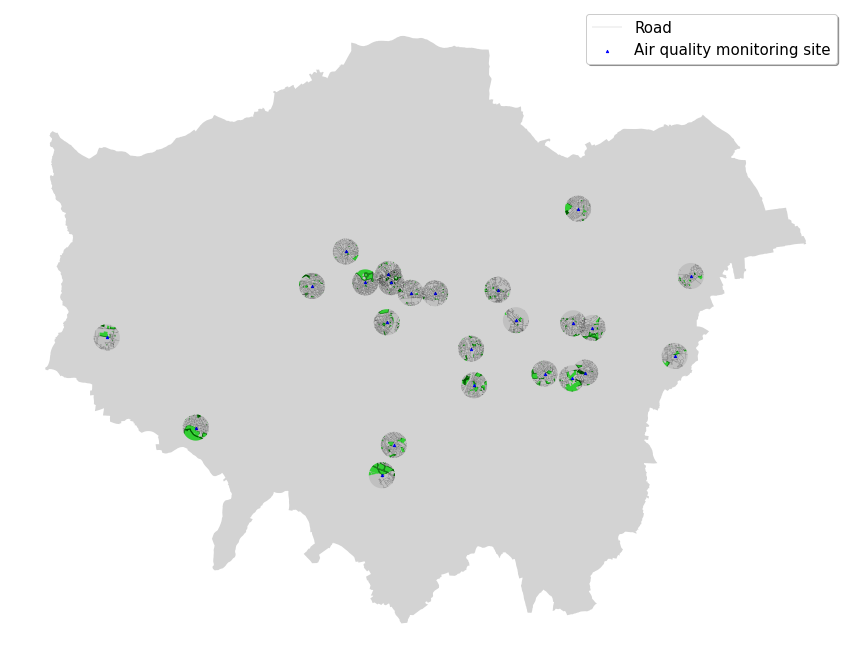

In [40]:
fig,ax=plt.subplots(1,figsize=(15,13))

london.plot(color='lightgrey',ax=ax)
loc_gdf['buffer_1km'].plot(color='silver',ax=ax)
loc_gdf['GreenSpace'].plot(label='Green space',color='limegreen',ax=ax)
loc_gdf['NR_GreenSpace'].plot(label='Near_road green space',color='darkgreen',ax=ax)
loc_gdf['Road'].plot(color='black',label='Road',linewidth=0.1,ax=ax)
loc_gdf['geometry'].plot(markersize=5,marker='^',color='blue',label='Air quality monitoring site',ax=ax)

ax.axis('off')

legend=ax.legend(loc='best',shadow=True,fontsize=15)

#plt.savefig('sample1.png',facecolor='black',dpi=500)
plt.show()

In [41]:
loc_gdf['min_dis']=pd.Series(dtype='float64')
for index, row in loc_gdf.iterrows():
    dis=[]
    for i, v in loc_gdf['geometry'].iteritems():
        dis.append(row['geometry'].distance(v))
    dis.remove(0)
    loc_gdf.loc[index,'min_dis']=min(dis)

In [42]:
loc_gdf[loc_gdf['min_dis']<=1500]

,sitename,geometry,buffer_1km,Road,GreenSpace,NR_GreenSpace,min_dis
siteid,,,,,,,
BL0,Camden - Bloomsbury,POINT (530120.048 182038.807),"POLYGON ((531120.048 182038.807, 531115.233 18...",MULTILINESTRING Z ((530175.051 181041.510 0.00...,"MULTIPOLYGON Z (((530885.507 181396.082 0.000,...","MULTIPOLYGON Z (((530885.507 181396.082 0.000,...",664.503439
CD9,Camden - Euston Road,POINT (529900.870 182666.124),"POLYGON ((530900.870 182666.124, 530896.055 18...",MULTILINESTRING Z ((529650.665 181699.144 0.00...,"MULTIPOLYGON Z (((530446.501 181828.697 0.000,...","MULTIPOLYGON Z (((530446.501 181828.697 0.000,...",664.503439
GR4,Greenwich - Eltham,POINT (543978.694 174655.234),"POLYGON ((544978.694 174655.234, 544973.878 17...",MULTILINESTRING Z ((544415.352 173756.882 0.00...,"MULTIPOLYGON Z (((544534.534 173823.964 0.000,...","MULTIPOLYGON Z (((544534.534 173823.964 0.000,...",1111.316933
GB0,Greenwich - Falconwood FDMS,POINT (544997.933 175098.152),"POLYGON ((545997.933 175098.152, 545993.118 17...",MULTILINESTRING Z ((544952.089 174100.404 0.00...,"MULTIPOLYGON Z (((545373.964 174171.892 0.000,...","MULTIPOLYGON Z (((545223.244 174124.937 0.000,...",1111.316933


In [43]:
AQMS_df[AQMS_df['Site'].isin(['BL0','CD9','GR4','GB0'])].groupby('Site').describe()

Value                                                                 \
      count       mean       std       min       25%        50%        75%   
Site                                                                         
BL0   362.0  10.792385  8.797994  2.130000  5.402083   7.372917  12.160417   
CD9   365.0  13.645846  8.812137  4.220833  8.208333  10.462500  15.316667   
GB0   362.0  12.297374  8.333113  3.975000  7.284375   9.604167  13.910417   
GR4   361.0  10.841191  8.419306  2.512500  5.939130   8.066667  11.712500   

                  code                                           
            max  count  mean  std   min   25%   50%   75%   max  
Site                                                             
BL0   48.720833  365.0  22.0  0.0  22.0  22.0  22.0  22.0  22.0  
CD9   53.466667  365.0  23.0  0.0  23.0  23.0  23.0  23.0  23.0  
GB0   73.420000  365.0   6.0  0.0   6.0   6.0   6.0   6.0   6.0  
GR4   62.054167  365.0   5.0  0.0   5.0   5.0   5.0   5.0   5.0

In [44]:
loc_gdf.drop(['BL0','GR4'],inplace=True)

In [59]:
df=AQMS_df.drop(AQMS_df[AQMS_df['Site'].isin(['BL0','GR4'])].index).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8030 entries, 0 to 8029
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DateTime  8030 non-null   object 
 1   Value     7030 non-null   float64
 2   Site      8030 non-null   object 
 3   code      8030 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 251.1+ KB


In [49]:
df.groupby('Site').describe()

Value                                                                 \
      count       mean       std       min       25%        50%        75%   
Site                                                                         
BX9   306.0  11.793728  9.561996  3.237500  5.887847   8.398160  13.435268   
CD1   362.0  11.099065  8.800779  2.150000  5.482292   7.970833  12.753125   
CD9   365.0  13.645846  8.812137  4.220833  8.208333  10.462500  15.316667   
CR8   364.0  10.116080  7.322826  2.625000  5.416667   7.583333  11.958333   
CT2   362.0  13.984774  7.898119  4.500000  9.093750  11.333333  15.197917   
CT3   333.0  11.690428  6.982014  3.136364  7.130435   9.458333  13.625000   
GB0   362.0  12.297374  8.333113  3.975000  7.284375   9.604167  13.910417   
GN0   137.0  11.927148  9.285710  3.287500  5.904348   8.650000  14.808333   
GN3   359.0  13.275893  9.658381  2.600000  7.283333   9.879167  15.420833   
GN6   348.0  11.040949  8.676238  2.391667  5.815625   7.693750  12.658333   
GR9   365.0  10.436627  9.191987  0.416667  4.704167   7.170833  12.370833   
HP1   365.0   9.932147  8.573924  1.983333  4.770833   6.695833  11.779167   
HV1   357.0  10.987333  8.971466  2.291667  5.483333   7.716667  12.370833   
KC1   364.0   9.575581  8.018949  2.262500  4.638542   6.558333  10.676042   
LH0   358.0   9.506291  7.872364  1.745833  4.646875   6.708333  11.165625   
LW2   330.0  14.897949  9.302770  4.563636  9.057813  11.495833  16.904167   
MY7   350.0  14.231996  9.382242  2.712500  8.202083  11.318750  16.333333   
RB7   148.0  11.598294  7.102626  1.500000  6.791667   9.583333  14.270833   
ST5   364.0  11.691002  8.140767  1.863636  6.802083   9.085145  13.416667   
TD5   350.0  11.733506  8.656932  2.254167  6.351042   8.637500  13.415625   
TH4   286.0  13.157072  9.453056  0.000000  7.400000   9.856250  15.915625   
WM0    95.0  11.718231  5.400732  5.958333  7.791667   9.458333  13.270833   

                  code                                           
            max  count  mean  std   min   25%   50%   75%   max  
Site                                                             
BX9   62.382609  365.0  21.0  0.0  21.0  21.0  21.0  21.0  21.0  
CD1   49.470833  365.0  24.0  0.0  24.0  24.0  24.0  24.0  24.0  
CD9   53.466667  365.0  23.0  0.0  23.0  23.0  23.0  23.0  23.0  
CR8   42.625000  365.0   3.0  0.0   3.0   3.0   3.0   3.0   3.0  
CT2   47.916667  365.0   1.0  0.0   1.0   1.0   1.0   1.0   1.0  
CT3   41.541667  365.0   2.0  0.0   2.0   2.0   2.0   2.0   2.0  
GB0   73.420000  365.0   6.0  0.0   6.0   6.0   6.0   6.0   6.0  
GN0   57.540000  365.0   4.0  0.0   4.0   4.0   4.0   4.0   4.0  
GN3   62.312500  365.0   8.0  0.0   8.0   8.0   8.0   8.0   8.0  
GN6   52.987500  365.0   7.0  0.0   7.0   7.0   7.0   7.0   7.0  
GR9   59.212500  365.0   9.0  0.0   9.0   9.0   9.0   9.0   9.0  
HP1   62.537500  365.0  13.0  0.0  13.0  13.0  13.0  13.0  13.0  
HV1   53.537500  365.0  10.0  0.0  10.0  10.0  10.0  10.0  10.0  
KC1   46.445833  365.0  12.0  0.0  12.0  12.0  12.0  12.0  12.0  
LH0   46.720833  365.0  11.0  0.0  11.0  11.0  11.0  11.0  11.0  
LW2   60.112500  365.0  14.0  0.0  14.0  14.0  14.0  14.0  14.0  
MY7   54.995833  365.0  20.0  0.0  20.0  20.0  20.0  20.0  20.0  
RB7   42.000000  365.0  16.0  0.0  16.0  16.0  16.0  16.0  16.0  
ST5   47.208333  365.0  17.0  0.0  17.0  17.0  17.0  17.0  17.0  
TD5   52.195833  365.0  15.0  0.0  15.0  15.0  15.0  15.0  15.0  
TH4   54.266667  365.0  18.0  0.0  18.0  18.0  18.0  18.0  18.0  
WM0   28.500000  365.0  19.0  0.0  19.0  19.0  19.0  19.0  19.0

In [57]:
df=df.merge(loc_gdf,left_on='Site',right_index=True)
df

,DateTime,Value,Site,code,sitename,geometry,buffer_1km,Road,GreenSpace,NR_GreenSpace,min_dis,buffer_area,pct_Gsp_area,pct_nR_Gsp_area
0,2019-01-01,7.458333,CT2,1,City of London - Farringdon Street,POINT (531622.273 181213.818),"POLYGON ((532622.273 181213.818, 532617.458 18...",MULTILINESTRING Z ((531654.940 180215.423 0.00...,"MULTIPOLYGON Z (((531473.204 182201.430 0.000,...","MULTIPOLYGON Z (((531473.204 182201.430 0.000,...",1713.851661,3.136548e+06,0.025462,0.019591
1,2019-01-02,14.913043,CT2,1,City of London - Farringdon Street,POINT (531622.273 181213.818),"POLYGON ((532622.273 181213.818, 532617.458 18...",MULTILINESTRING Z ((531654.940 180215.423 0.00...,"MULTIPOLYGON Z (((531473.204 182201.430 0.000,...","MULTIPOLYGON Z (((531473.204 182201.430 0.000,...",1713.851661,3.136548e+06,0.025462,0.019591
2,2019-01-03,24.083333,CT2,1,City of London - Farringdon Street,POINT (531622.273 181213.818),"POLYGON ((532622.273 181213.818, 532617.458 18...",MULTILINESTRING Z ((531654.940 180215.423 0.00...,"MULTIPOLYGON Z (((531473.204 182201.430 0.000,...","MULTIPOLYGON Z (((531473.204 182201.430 0.000,...",1713.851661,3.136548e+06,0.025462,0.019591
3,2019-01-04,10.541667,CT2,1,City of London - Farringdon Street,POINT (531622.273 181213.818),"POLYGON ((532622.273 181213.818, 532617.458 18...",MULTILINESTRING Z ((531654.940 180215.423 0.00...,"MULTIPOLYGON Z (((531473.204 182201.430 0.000,...","MULTIPOLYGON Z (((531473.204 182201.430 0.000,...",1713.851661,3.136548e+06,0.025462,0.019591
4,2019-01-05,18.125000,CT2,1,City of London - Farringdon Street,POINT (531622.273 181213.818),"POLYGON ((532622.273 181213.818, 532617.458 18...",MULTILINESTRING Z ((531654.940 180215.423 0.00...,"MULTIPOLYGON Z (((531473.204 182201.430 0.000,...","MULTIPOLYGON Z (((531473.204 182201.430 0.000,...",1713.851661,3.136548e+06,0.025462,0.019591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8025,2019-12-27,15.625000,CD1,24,Camden - Swiss Cottage,POINT (526629.730 184391.024),"POLYGON ((527629.730 184391.024, 527624.915 18...",MULTILINESTRING Z ((526806.590 183407.535 0.00...,"MULTIPOLYGON Z (((527584.073 184093.479 0.000,...","MULTIPOLYGON Z (((527584.073 184093.479 0.000,...",2806.536146,3.136548e+06,0.035043,0.012352
8026,2019-12-28,15.200000,CD1,24,Camden - Swiss Cottage,POINT (526629.730 184391.024),"POLYGON ((527629.730 184391.024, 527624.915 18...",MULTILINESTRING Z ((526806.590 183407.535 0.00...,"MULTIPOLYGON Z (((527584.073 184093.479 0.000,...","MULTIPOLYGON Z (((527584.073 184093.479 0.000,...",2806.536146,3.136548e+06,0.035043,0.012352
8027,2019-12-29,15.062500,CD1,24,Camden - Swiss Cottage,POINT (526629.730 184391.024),"POLYGON ((527629.730 184391.024, 527624.915 18...",MULTILINESTRING Z ((526806.590 183407.535 0.00...,"MULTIPOLYGON Z (((527584.073 184093.479 0.000,...","MULTIPOLYGON Z (((527584.073 184093.479 0.000,...",2806.536146,3.136548e+06,0.035043,0.012352
8028,2019-12-30,19.683333,CD1,24,Camden - Swiss Cottage,POINT (526629.730 184391.024),"POLYGON ((527629.730 184391.024, 527624.915 18...",MULTILINESTRING Z ((526806.590 183407.535 0.00...,"MULTIPOLYGON Z (((527584.073 184093.479 0.000,...","MULTIPOLYGON Z (((527584.073 184093.479 0.000,...",2806.536146,3.136548e+06,0.035043,0.012352


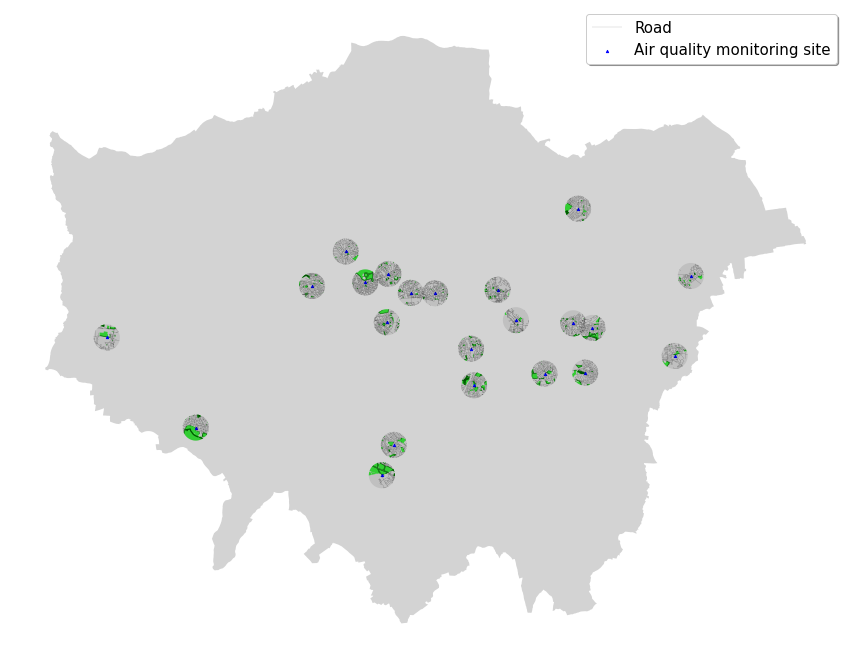

In [50]:
fig,ax=plt.subplots(1,figsize=(15,13))

london.plot(color='lightgrey',ax=ax)
loc_gdf['buffer_1km'].plot(color='silver',ax=ax)
loc_gdf['GreenSpace'].plot(label='Green space',color='limegreen',ax=ax)
loc_gdf['NR_GreenSpace'].plot(label='Near_road green space',color='darkgreen',ax=ax)
loc_gdf['Road'].plot(color='black',label='Road',linewidth=0.1,ax=ax)
loc_gdf['geometry'].plot(markersize=5,marker='^',color='blue',label='Air quality monitoring site',ax=ax)

ax.axis('off')

legend=ax.legend(loc='best',shadow=True,fontsize=15)

#plt.savefig('sample1.png',facecolor='black',dpi=500)
plt.show()

In [51]:
loc_gdf['buffer_area']=loc_gdf['buffer_1km'].area

In [52]:
loc_gdf['pct_Gsp_area']=loc_gdf['GreenSpace'].area/loc_gdf['buffer_area'] # percentage of gsp area
loc_gdf['pct_nR_Gsp_area']=loc_gdf['NR_GreenSpace'].area/loc_gdf['buffer_area'] # percentage of near road gsp area

In [53]:
loc_gdf.head()

,sitename,geometry,buffer_1km,Road,GreenSpace,NR_GreenSpace,min_dis,buffer_area,pct_Gsp_area,pct_nR_Gsp_area
siteid,,,,,,,,,,
BX9,Bexley - Slade Green FDMS,POINT (551862.205 176375.976),"POLYGON ((552862.205 176375.976, 552857.390 17...",MULTILINESTRING Z ((552075.170 175434.690 0.00...,"MULTIPOLYGON Z (((551286.362 175559.542 0.000,...","MULTIPOLYGON Z (((551286.362 175559.542 0.000,...",6262.058504,3.136548e+06,0.062358,0.022665
CD9,Camden - Euston Road,POINT (529900.870 182666.124),"POLYGON ((530900.870 182666.124, 530896.055 18...",MULTILINESTRING Z ((529650.665 181699.144 0.00...,"MULTIPOLYGON Z (((530446.501 181828.697 0.000,...","MULTIPOLYGON Z (((530446.501 181828.697 0.000,...",664.503439,3.136548e+06,0.052833,0.042514
CD1,Camden - Swiss Cottage,POINT (526629.730 184391.024),"POLYGON ((527629.730 184391.024, 527624.915 18...",MULTILINESTRING Z ((526806.590 183407.535 0.00...,"MULTIPOLYGON Z (((527584.073 184093.479 0.000,...","MULTIPOLYGON Z (((527584.073 184093.479 0.000,...",2806.536146,3.136548e+06,0.035043,0.012352
CT2,City of London - Farringdon Street,POINT (531622.273 181213.818),"POLYGON ((532622.273 181213.818, 532617.458 18...",MULTILINESTRING Z ((531654.940 180215.423 0.00...,"MULTIPOLYGON Z (((531473.204 182201.430 0.000,...","MULTIPOLYGON Z (((531473.204 182201.430 0.000,...",1713.851661,3.136548e+06,0.025462,0.019591
CT3,City of London - Sir John Cass School,POINT (533480.243 181186.837),"POLYGON ((534480.243 181186.837, 534475.427 18...",MULTILINESTRING Z ((533123.210 180253.779 0.00...,"MULTIPOLYGON Z (((534480.226 181186.502 0.000,...","MULTIPOLYGON Z (((534480.226 181186.502 0.000,...",1858.165217,3.136548e+06,0.016023,0.015215


In [60]:
df.head()

,DateTime,Value,Site,code
0,2019-01-01,7.458333,CT2,1
1,2019-01-02,14.913043,CT2,1
2,2019-01-03,24.083333,CT2,1
3,2019-01-04,10.541667,CT2,1
4,2019-01-05,18.125000,CT2,1


In [55]:
cond.head()

,DateTime,BP,Tmp,RH
0,2019-01-01,1029.864583,8.729167,75.312500
1,2019-01-02,982.156250,1.885417,96.145833
2,2019-01-03,1010.770833,9.300000,85.805556
3,2019-01-04,1011.833333,8.816667,73.750000
4,2019-01-05,1010.125000,12.500000,72.222222


In [61]:
df=df.merge(cond,on='DateTime')
df.head()

,DateTime,Value,Site,code,BP,Tmp,RH
0,2019-01-01,7.458333,CT2,1,1029.864583,8.729167,75.3125
1,2019-01-01,7.083333,CT3,2,1029.864583,8.729167,75.3125
2,2019-01-01,9.333333,CR8,3,1029.864583,8.729167,75.3125
3,2019-01-01,7.141667,GN0,4,1029.864583,8.729167,75.3125
4,2019-01-01,8.279167,GB0,6,1029.864583,8.729167,75.3125


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8030 entries, 0 to 8029
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DateTime  8030 non-null   object 
 1   Value     7030 non-null   float64
 2   Site      8030 non-null   object 
 3   code      8030 non-null   int64  
 4   BP        8008 non-null   float64
 5   Tmp       7876 non-null   float64
 6   RH        8008 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 501.9+ KB


In [63]:
loc_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 22 entries, BX9 to MY7
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   sitename         22 non-null     object  
 1   geometry         22 non-null     geometry
 2   buffer_1km       22 non-null     geometry
 3   Road             22 non-null     geometry
 4   GreenSpace       22 non-null     geometry
 5   NR_GreenSpace    22 non-null     geometry
 6   min_dis          22 non-null     float64 
 7   buffer_area      22 non-null     float64 
 8   pct_Gsp_area     22 non-null     float64 
 9   pct_nR_Gsp_area  22 non-null     float64 
dtypes: float64(4), geometry(5), object(1)
memory usage: 1.9+ KB


In [64]:
df=df.merge(loc_gdf,left_on='Site',right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8030 entries, 0 to 8029
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   DateTime         8030 non-null   object  
 1   Value            7030 non-null   float64 
 2   Site             8030 non-null   object  
 3   code             8030 non-null   int64   
 4   BP               8008 non-null   float64 
 5   Tmp              7876 non-null   float64 
 6   RH               8008 non-null   float64 
 7   sitename         8030 non-null   object  
 8   geometry         8030 non-null   geometry
 9   buffer_1km       8030 non-null   geometry
 10  Road             8030 non-null   geometry
 11  GreenSpace       8030 non-null   geometry
 12  NR_GreenSpace    8030 non-null   geometry
 13  min_dis          8030 non-null   float64 
 14  buffer_area      8030 non-null   float64 
 15  pct_Gsp_area     8030 non-null   float64 
 16  pct_nR_Gsp_area  8030 non-null   float64 


In [ ]:
var=['pct_Gsp_area','pct_nR_Gsp_area','BP','Tmp','RH']

In [ ]:
from spreg import OLS

m_multi=OLS(y=df.dropna()['Value'].values, name_y='PM2.5 reading',
            x=df.dropna()[var].values,name_x=var)
print(m_multi.summary)